<a href="https://colab.research.google.com/github/Arnab-Bordoloi/Arnab-Bordoloi/blob/main/skimlit_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# confirm access to GPU

In [1]:
!nvidia-smi

Sun Sep 26 16:10:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-8bfc14c1-012a-54c3-0a3d-b33f87eeb28c)


## Get data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct/

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# chck what file are there in PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:

data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'
# check all file names in data directory
import os
data_filemames_list = [data_dir + '/'+i for i in os.listdir(data_dir)]
data_filemames_list

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess data

In [6]:
# create function to read the lines of the document
def get_lines(filename):
  """
  reads a text file and returns the lines in a list
  Args :
      filename with filepath
  Returns:
      a list of lines from the input file    
  """
  with open(filename, "r") as f:
     # With as a context manager
     return f.readlines()


In [7]:
# Reading the training test lines
train_lines = get_lines("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt")
len(train_lines)

35135

In [8]:
train_lines[:1]

['###24845963\n']

In [9]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for i in input_lines:
    if i.startswith("###"):
      abstract_id = i
      abstract_lines = ""
    elif i.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for cnt, j in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = j.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = cnt
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      #abstract_lines = abstract_lines + line
      abstract_lines += i
  return abstract_samples

In [10]:
%%time
test_samples = preprocess_text_with_line_numbers(data_dir+'/'+"test.txt")
validation_samples = preprocess_text_with_line_numbers(data_dir+'/'+"dev.txt")
train_samples = preprocess_text_with_line_numbers(data_dir+'/'+"train.txt")

print(len(test_samples),len(validation_samples),len(train_samples))

30135 30212 180040
CPU times: user 454 ms, sys: 112 ms, total: 566 ms
Wall time: 570 ms


# Checking the samples in dictionary form

In [11]:
train_samples[:50]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

# Converting the list with dictionary to dataframe

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
validation_df = pd.DataFrame(validation_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

# Checking the length of different lines

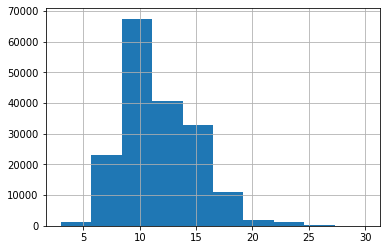

In [15]:
train_df.total_lines.hist();

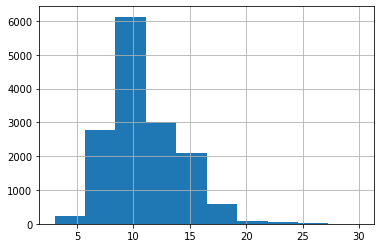

In [16]:
train_df[train_df['line_number']==0].total_lines.hist();

In [17]:
train_sentences = train_df["text"].to_list()
validation_sentences = validation_df["text"].to_list()
test_sentences = test_df["text"].to_list()

In [18]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# turning labels into numeric form

In [19]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [21]:
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1,1))
validation_labels_one_hot = one_hot_encoder.transform(validation_df.target.to_numpy().reshape(-1,1))

# Also label encoding

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_label_encode = label_encoder.fit_transform(train_df.target.to_numpy())
test_labels_label_encode = label_encoder.transform(test_df.target.to_numpy())
validation_labels_label_encode = label_encoder.transform(validation_df.target.to_numpy())

In [23]:
train_labels_label_encode

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Model 0 - Naive Bayes and TF IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# creating a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())                    
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences
            ,y=train_labels_label_encode)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [26]:
# Evaluate on validation dataset
model_0.score(X=validation_sentences
                 ,y=validation_labels_label_encode)

0.7218323844829869

In [27]:
baseline_preds = model_0.predict(validation_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
validation_labels_label_encode

array([0, 0, 3, ..., 4, 1, 1])

In [29]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-26 16:11:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-26 16:11:30 (23.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [30]:
from helper_functions import calculate_results

In [31]:
baseline_result = calculate_results(y_true=validation_labels_label_encode
                                    ,y_pred=baseline_preds)
baseline_result

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [33]:
sent_len = [len(i.split()) for i in train_sentences]
avg_sen_len = np.mean(sent_len)
avg_sen_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

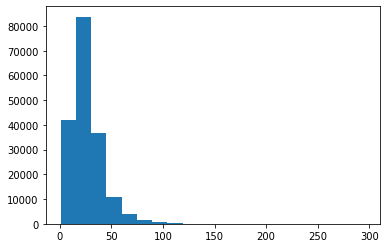

In [34]:
import matplotlib.pyplot as plt
plt.hist(sent_len, bins = 20)

In [35]:
np.percentile(sent_len,95)

55.0

In [36]:
llist = [99,98,70,49,87,23,87,34,56,57]
np.mean(llist), np.percentile(llist,50)

(66.0, 63.5)

In [37]:
considered_sent_len = int(np.percentile(sent_len,95))

In [38]:
considered_sent_len

55

# text vectorization

In [39]:
max_token = 68000

In [40]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_token
                  ,output_sequence_length = considered_sent_len)

In [41]:
text_vectorizer.adapt(train_sentences)

In [42]:
# test text_vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text\n:{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text
:varenicline did not improve cognition , behavior or global change in this population .

Length of text: 14

Vectorized text: [[3022  112   31  218 2087  684   16  647  133    5   23  278    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [43]:
vocabulary = text_vectorizer.get_vocabulary()
len(vocabulary)

64841

In [44]:
print(f"number of words: {len(text_vectorizer.get_vocabulary())}")
print(f"most common words: {text_vectorizer.get_vocabulary()[:5]}")
print(f"least common words: {text_vectorizer.get_vocabulary()[-5:]}")

number of words: 64841
most common words: ['', '[UNK]', 'the', 'and', 'of']
least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [45]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

# Custom text embedding

In [46]:
token_embed = layers.Embedding(input_dim = len(vocabulary)
                                               ,output_dim = 128
                                               ,mask_zero=True
                                               ,name = "token_embedding")

In [47]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization and before enbedding:\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Shape of embedded sentence:\n{embedded_sentence.shape}\n")

Sentence before vectorization:
varenicline did not improve cognition , behavior or global change in this population .

Sentence after vectorization and before enbedding:
[[3022  112   31  218 2087  684   16  647  133    5   23  278    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.04256246  0.00536932 -0.0441764  ...  0.02605752  0.00282573
   -0.03477629]
  [-0.00890602  0.00976389 -0.03978448 ... -0.01358107  0.00100172
   -0.03458523]
  [-0.03009042 -0.02231821  0.04454944 ...  0.03398469 -0.03752228
    0.02623114]
  ...
  [-0.01177701 -0.00156498 -0.02128019 ...  0.04220405 -0.0199198
    0.03362672]
  [-0.01177701 -0.00156498 -0.02128019 ...  0.04220405 -0.0199198
    0.03362672]
  [-0.01177701 -0.00156498 -0.02128019 ...  0.04220405 -0.0199198
    0.03362672]]]

Shape of embed

# Creating datasets for tensorflow so that it runs as fast as possible

In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [49]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

# Model 1 with Conv1D with token embedding

In [52]:
# Create a 1D conv model to process sequence
inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding= "same", activation= "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(len(label_encoder.classes_), activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [53]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [54]:
len(train_dataset), len(validation_dataset)

(5627, 945)

In [55]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = validation_dataset,
                              validation_steps = int(0.1 * len(validation_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 14ms/step - loss: 0.9079 - accuracy: 0.6431 - val_loss: 0.6818 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.6571 - accuracy: 0.7576 - val_loss: 0.6313 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6177 - accuracy: 0.7753 - val_loss: 0.5972 - val_accuracy: 0.7872


In [56]:
#evaluate on the whole validation dataset
model_1.evaluate(validation_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5976 - accuracy: 0.7879


[0.5976402163505554, 0.7878657579421997]